<a href="https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/main/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

Wikipedia, as the name implies, is the Encyclopedia of the 21st century. It is an amazing place full of free information mantained by a community of volenteer editors. It has assisted in the removal of barriers when it comes to giving and receiving knwoledge. Unfortunatley, with this great democritization comes the potential spread of misinformation and plagarized content. With the rise of complex transformer models such as GPT2, AI can generate persuasive content that is practically identical to human written text.
See what I mean!: https://techcrunch.com/2019/02/17/openai-text-generator-dangerous/

This is where machine learning can help! We can train a Machine learning model to classify whether or not a body of text has been written by a human or an AI and use other NLP strategies to catch plagarism. If this seems like a problem you care about then keep reading!

* Spencer Holley
* aacjpw@gmail.com
* https://github.com/spe301/Wikipedia-Capstone

## Use cases

* wikipedia users and contributers can flag AI generated articles
* prevent AI generated fake news from spreading
* teachers and professors can flag AI generated essays 

## Potosnail Library

learn more at https://github.com/spe301/Potosnail

In [2]:
# restart runtime after installing Potosnail
!pip install Potosnail==0.0.5
#from potosnail import MachineLearning, DeepLearning, DataHelper, Evaluater

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt

def ModelReadyString(text_str, pad):
  '''converts an individual unit of text into tokenized sequences'''
  text = [text_str]
  t = Tokenizer()
  t.fit_on_texts(text)
  tokens = t.texts_to_sequences(text)
  tokens2 = pad_sequences(tokens, maxlen=pad)
  return tokens2

ml = MachineLearning()
dl = DeepLearning()
dh = DataHelper()
ev = Evaluater()

## Obtain Data

We will concatenate the 180 generated articles with 180 randomly selected real articles

Check out my other notebook if you want to see how the generated articles were made!

https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/main/WikiFakes.ipynb

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/HumanText.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis='columns')
df2 = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/Generated%20(1).csv').drop(['Unnamed: 0'], axis='columns')
data = pd.concat([df.sample(n=180), df2])
data

,Text,Human,AI
341,improvisation is the activity of making or doi...,1,0
363,"joseph robinette biden jr. in august, he anno...",1,0
851,5 0 bce 0 bce.coin of lycia. circa 5200-470 bc...,1,0
688,sport includes all forms of competitive physic...,1,0
336,ian j. goodfellow he was previously employed ...,1,0
...,...,...,...
175,by jonathan rosen\n\njonathan rosen is a senio...,0,1
176,he was able to maintain good relations with t...,0,1
177,mealworms are shed during the larval phase of ...,0,1
178,"by\n\nby 2015, syrian president muammar gaddaf...",0,1


## Data Preproccessing 

In [5]:
#finding average number of words per document to determine padding
avg = 0
for i in range(len(data['Text'])):
  avg += len(list(data['Text'])[i].split(' '))/len(data)

pad = int(avg)
pad

1720

In [6]:
train, test = dh.HoldOut(data)

In [7]:
text, lables = dl.ModelReadyText1(train['Text'], train['AI'], pad)
Xtest, ytest = dl.ModelReadyText1(test['Text'], test['AI'], pad)

In [8]:
text

array([[    4,   489,     8, ...,    82,     1,   909],
       [    0,     0,     0, ...,  1073, 18916,  2226],
       [    0,     0,     0, ...,   114,   902,   404],
       ...,
       [    0,     0,     0, ...,     5,     1,   591],
       [    0,     0,     0, ...,   172,   238,    18],
       [    0,     0,     0, ...,  1236,   266,   592]], dtype=int32)

In [9]:
lables
#[0, 1] is AI generated and [1, 0] is real

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [10]:
# finding total vocab size of all documents to determine embedding
words = []
for i in range(len(train)):
  word_lst = list(train['Text'])[i].replace('\n', ' ').split(' ')
  for word in word_lst:
    words.append(word.replace('.', '').replace(',', '').replace(' ', '').replace('"', '').replace(':', '').replace(';', '').replace('!', ''))

vocab = len(np.unique(words))
vocab

43054

# Modeling

the following cell takes 8 hours to run. if you want to build and train a quick model use dl.RNN() or dl.FastRNN()

In [12]:
params = {'output_dim': [2], #because we have 2 classes
          'embedding': [vocab], #vocab is number of unique words in dataset
          'nodes': [32, 64], #we will test between 32 and 64 nodes for the first layer
          'activation': ['tanh'], #we will test between relu and tanh for activation function
          'regularizer': ['L1', None], #we will use L1 reqularization to prevent overfitting
          'stacking': [False], #stacking makes the first 2 layers the same, we will not do this
          'dropout': [False, True], #we will not use dropout because we are already using L1 regularization
          'optimizer': ['adam'], #we will test between adam and rmsprop for optimization function
          'method': ['LSTM', 'GRU'], #we will test between using an LSTM cell and a GRU cell
          'bidirectional': [True, False]} #we will test between a bidirectional RNN and a standard RNN
grid = dl.TestDL(params, dl.RNN, 'classification', text, lables, batch_size=64)
grid.best_estimator_.model.save('drive/MyDrive/model2.h5')

Streaming output truncated to the last 5000 lines.
Epoch 15/50
3/3 [==============================] - 6s 2s/step - loss: 0.1038 - accuracy: 1.0000 - val_loss: 0.5606 - val_accuracy: 0.7500
Epoch 16/50
3/3 [==============================] - 6s 2s/step - loss: 0.1023 - accuracy: 0.9951 - val_loss: 0.3794 - val_accuracy: 0.8409
Epoch 17/50
3/3 [==============================] - 6s 2s/step - loss: 0.0897 - accuracy: 1.0000 - val_loss: 0.5025 - val_accuracy: 0.7955
Epoch 18/50
3/3 [==============================] - 6s 2s/step - loss: 0.0842 - accuracy: 1.0000 - val_loss: 0.5836 - val_accuracy: 0.7500
Epoch 19/50
3/3 [==============================] - 6s 2s/step - loss: 0.0792 - accuracy: 1.0000 - val_loss: 0.5966 - val_accuracy: 0.7727
Epoch 20/50
3/3 [==============================] - 7s 2s/step - loss: 0.0750 - accuracy: 1.0000 - val_loss: 0.6061 - val_accuracy: 0.7727
Epoch 21/50
3/3 [==============================] - 6s 2s/step - loss: 0.0708 - accuracy: 1.0000 - val_loss: 0.6147 - val_

## Evaluation of best model with potosnail

In [24]:
grid.best_params_

{'activation': 'tanh',
 'bidirectional': True,
 'dropout': True,
 'embedding': 43054,
 'method': 'GRU',
 'nodes': 32,
 'optimizer': 'adam',
 'output_dim': 2,
 'regularizer': None,
 'stacking': False}

In [20]:
model = models.load_model('drive/MyDrive/model2.h5')
model.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_108 (Embedding)    (None, None, 32)          1377728   
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 64)                12672     
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_270 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_271 (Dense)            (None, 2)                 34        
Total params: 1,391,474
Trainable params: 1,391,474
Non-trainable params: 0
_________________________________________________________________


The best model was a bidirectional GRU with tanh activation, adam optimization, and L1 reguarization.

In [25]:
X, y = dl.ModelReadyText1(test['Text'], test['AI'], pad)
grid.best_estimator_.score(X, y)

2/2 [==============================] - 0s 72ms/step - loss: 0.4071 - accuracy: 0.8889


0.8888888955116272

In [26]:
grid.best_estimator_.score(text, lables)

11/11 [==============================] - 1s 119ms/step - loss: 0.0872 - accuracy: 0.9784


0.9783950448036194

We have 97.8% training accuracy but only 88.8% testing. This indicates overfitting. 

this model did well. it properly classified 94% of AI generated articles and 84% of the real ones, we can't have this! The model was a Bidirectional GRU that used Dropout regularization.

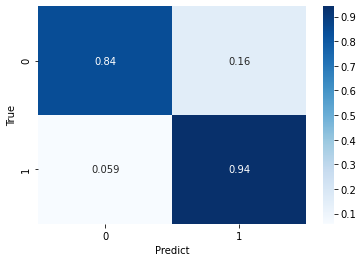

In [27]:
ev.BuildConfusionDL(model, Xtest, ytest, cmap='Blues')

## The best Model before Potosnail

This model was created using  a similar gridsearch.

In [30]:
model2 = models.load_model('drive/MyDrive/BidFinal.h5')
model2.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     (None, None, 64)          2939584   
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_216 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_217 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_218 (Dense)            (None, 2)                 34        
Total params: 3,010,322
Trainable params: 3,010,322
Non-trainable params: 0
_________________________________________________________________


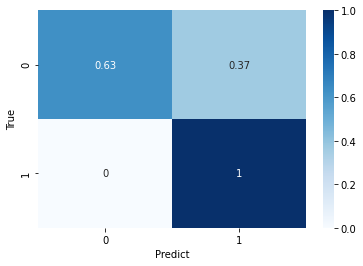

In [29]:
ev.BuildConfusionDL(model2, Xtest, ytest, cmap='Blues')

Although this model properly classified 100% of AI generated articles, but only 67% of the real ones. The previous model is best because it's accuracies are more balanced among classes.

## Going further with BidFinal

I am going with this one because there was a better TPR (True Positive Rate).

In [31]:
model2.evaluate(Xtest, ytest);

2/2 [==============================] - 1s 142ms/step - loss: 0.4974 - accuracy: 0.8056


In [32]:
model.evaluate(Xtest, ytest);

2/2 [==============================] - 1s 112ms/step - loss: 0.4071 - accuracy: 0.8889


In [33]:
model2.evaluate(text, lables);

11/11 [==============================] - 3s 281ms/step - loss: 0.4129 - accuracy: 0.8364


In [34]:
model.evaluate(text, lables);

11/11 [==============================] - 2s 142ms/step - loss: 0.0872 - accuracy: 0.9784


In [35]:
test.reset_index(inplace=True)

Testing the model on a random article

In [45]:
sample = test.iloc[np.random.randint(35)]
truth = sample['AI']
text_str = sample['Text']
output = model.predict(ModelReadyString(text_str, pad))
output2 = model2.predict(ModelReadyString(text_str, pad))
print('model predicts a {}% probability that an AI wrote this.'.format(round(output[0][1]*100, 2)))
print('model2 predicts a {}% probability that an AI wrote this.'.format(round(output2[0][1]*100, 2)))

model predicts a 5.03% probability that an AI wrote this.
model2 predicts a 6.32% probability that an AI wrote this.


In [46]:
sample

index                                                   98
Text     britney jean spears  due to a series of highly...
Human                                                    1
AI                                                       0
Name: 12, dtype: object

In [47]:
text_str

'britney jean spears  due to a series of highly publicized personal struggles, promotion for the album was limited and she was later involuntarily placed in a conservatorship. since then, she released the chart-topping albums, circus  she also has four solo number-one singles on the us billboard hot 100: "...baby one more time", "womanizer", "3", and "hold it against me". as a featured artist, the "s&m" remix also topped the billboard chart. other singles, "oops!... i did it again", "toxic", and "scream & shout", topped the charts in most countries. with "3" in 2009 and "hold it against me" in 2011, she became the second artist after mariah carey in the hot 100s history to debut at number one with two or more songs. spearss heavily choreographed videography is considered a focal point to the success of her career, for which she has been awarded the michael jackson video vanguard award. she has earned numerous awards and accolades, including a grammy award; thirteen guinness world recor

## Text EDA

1. What would a wordcloud look like for these two seperate collections of text?

insight: first was a major word for both the AI written and Human written articles because the articles often mention that the topic was or is the first to do or be something in particular. United States and german were major in the AI written text because there were many political articles whereas the real articles used terms more general words, like may and many, because they were over a wider variety of topics

In [39]:
AI = ','.join(data.loc[data['AI']==1]['Text'])
Human = ','.join(df['Text'])

In [40]:
AiCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(AI)
HumanCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(Human)

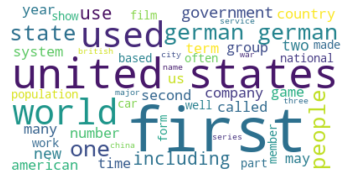

In [41]:
plt.imshow(AiCloud, interpolation='bilinear');
plt.axis('off')
plt.show()

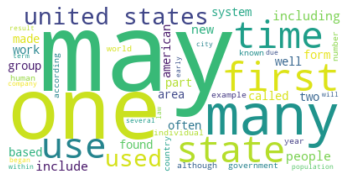

In [42]:
plt.imshow(HumanCloud, interpolation='bilinear');
plt.axis('off')
plt.show()

2. What percentage of AI generated text is stopwords compared to the human written text?

insight: both have very little stopwords but the real articles have a slightly lower use of stopwords at 0.39% compared to 0.44%

In [43]:
#finding the percentage of words in the AI generated text that are stopwords
AiWords = AI.split(' ')
HumanWords = Human.split(' ')
AiStoppers = 0
for word in AiWords:
  if word in list(STOPWORDS):
    AiStoppers += 1

#finding the percentage of words in the real articles that are stopwords
HumanStoppers = 0
for word in HumanWords:
  if word in list(STOPWORDS):
    HumanStoppers += 1

print('the AI written text is {}% stopwords and the Human written text is {}% stopwords'.format(round(AiStoppers/len(AiWords), 2), round(HumanStoppers/len(HumanWords), 2)))

the AI written text is 0.44% stopwords and the Human written text is 0.39% stopwords


## Reccomendations / Conculsions
These are some ways an AI written text classifier can be used
1. Teachers and professors can flag AI generated text in there student's work.
2. News companies can use this to verify that the news stories that come in really came from their reporters instead of a bot.
3. Wikipedia users and contributers can flag AI generated text on the site.
